In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [3]:
# For implementing cylindrical coordinates
solver1D_from = lambda i: readwritedatafiles.read_data_file(
  f"tung_conduit1_{i}.pkl")
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung_atm{j}_{i}.pkl")

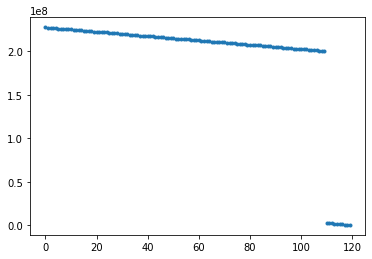

In [153]:
solver_ = readwritedatafiles.read_data_file(
  f"tung2_conduit1_0.pkl")
plt.plot(solver_.physics.compute_variable("Pressure", solver_.state_coeffs).ravel(), '.')

In [187]:
# Grab 0 state
p_hydro = [mdtools.downsample(solver2D_from(0, j+1), plot_qty="Pressure")[1] for j in range(5)]

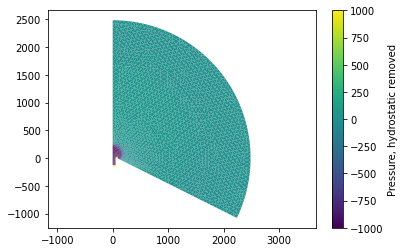

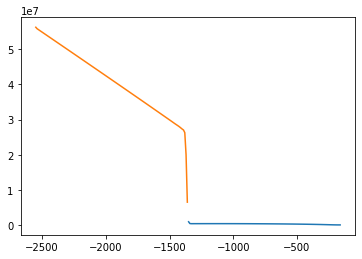

In [207]:
solver1D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung2_conduit{j}_{i}.pkl")

for i in range(20):
  plt.figure(1)
  plt.clf()
  for j in range(3):
    x1, v = mdtools.downsample(solver2D_from(i, j+1), plot_qty="Pressure")
    clims = (-1e3,1e3)
    mdtools.plot_mean(x1, v-p_hydro[j], clims)

  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  cb.set_label("Pressure, hydrostatic removed")
  plt.savefig(f"out2D_{i}.png")

  plt.figure(2)
  plt.clf()
  for j in [1,2]:
    x1, v = mdtools.downsample(solver1D_from(i, j), plot_qty="Pressure")
    plt.plot(x1[:,0,:].squeeze(), v[:,0,:].squeeze())
  plt.savefig(f"out1D_{i}.png")
  

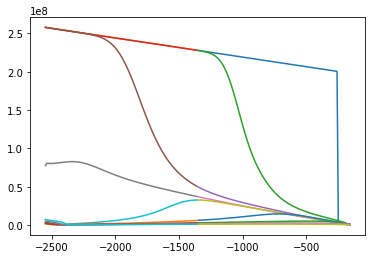

In [209]:
for i in range(10):
  for j in [1,2]:
    x1, v = mdtools.downsample(solver1D_from(i, j), plot_qty="Pressure")
    plt.plot(x1[:,0,:].squeeze(), v[:,0,:].squeeze())

In [247]:
# Volume flow rate
volflow = []
massflow = []
t_volflow = []
t_wavetravel_array = []
for i in range(120):
  s = solver1D_from(i, 1)
  volflow.append(np.pi * 50**2 * 
      s.state_coeffs[-1,-1,3] / np.sum(s.state_coeffs[-1,-1,0:3])
  )
  massflow.append(
    np.pi * 50**2 * 
      s.state_coeffs[-1,-1,3]
  )
  t_volflow.append(s.time)
  # Compute average sound speed
  c1 = s.physics.compute_variable("SoundSpeed", s.state_coeffs[:,:,:]).squeeze()
  s2 = solver1D_from(i, 2)
  c2 = s2.physics.compute_variable("SoundSpeed", s2.state_coeffs[:,:,:]).squeeze()
  import scipy.stats
  meanspeed = scipy.stats.hmean(np.concatenate((c1, c2)))
  L = s.mesh.node_coords.max() - s2.mesh.node_coords.min()
  t_wavetravel = L / meanspeed
  t_wavetravel_array.append(t_wavetravel)
  
volflow = np.array(volflow)
massflow = np.array(massflow)
t_volflow = np.array(t_volflow)
t_wavetravel_array = np.array(t_wavetravel_array)

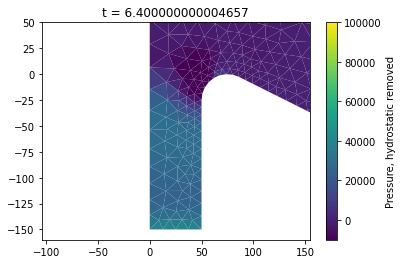

In [294]:
# Near-vent plot
i = 16

for j in range(1):
  s = solver2D_from(i, j+1)
  x1, v = mdtools.downsample(s, plot_qty="Pressure")
  clims = (-1e4,1e5)
  mdtools.plot_mean(x1, v-p_hydro[j], clims)
  plt.title(f"t = {s.time}")
# mdtools.plot_mean(x1, v-p_hydro[j], clims)
plt.xlim((0, 50))
plt.ylim((-160,50))

sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
cb.set_label("Pressure, hydrostatic removed")

102688.3269109908

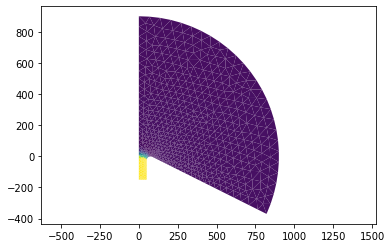

In [340]:
mdtools.plot_mean(x, s.physics.compute_variable("SoundSpeed", solver2D_from(10,1).state_coeffs) \
  * np.sum(solver2D_from(10,1).state_coeffs[...,0:3], axis=-1, keepdims=True), (0, 10000))
(s.physics.compute_variable("SoundSpeed", solver2D_from(10,1).state_coeffs) \
  * np.sum(solver2D_from(10,1).state_coeffs[...,0:3], axis=-1, keepdims=True)).max()

In [ ]:
# (Import) Plot volfrac density
import matplotlib.animation as animation

outfilename = "imped2"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(), f"{outfilename}.mp4")

# plot_idx = 20

for plot_idx in [i+1 for i in range(0,150,1)]:
  plt.clf()
  clims = (0,1e5)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    rho = np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True)
    yM = solver.state_coeffs[:,:,2:3] / rho
    Z = solver.physics.compute_variable("SoundSpeed", solver.state_coeffs) \
      * np.sum(solver.state_coeffs[...,0:3], axis=-1, keepdims=True)
    mdtools.plot_mean(x, Z, clims)

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("Magma mass fraction")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

Done


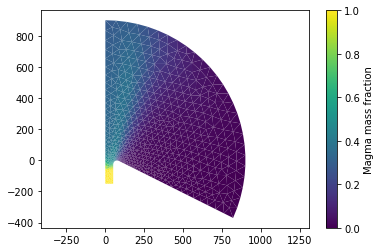

In [325]:
# (Import) Plot volfrac density
import matplotlib.animation as animation

outfilename = "yM_2"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(), f"{outfilename}.mp4")

# plot_idx = 20

for plot_idx in [i+1 for i in range(0,150,1)]:
  plt.clf()
  clims = (0,1)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    rho = np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True)
    yM = solver.state_coeffs[:,:,2:3] / rho
    mdtools.plot_mean(x, yM, clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("Magma mass fraction")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

Done


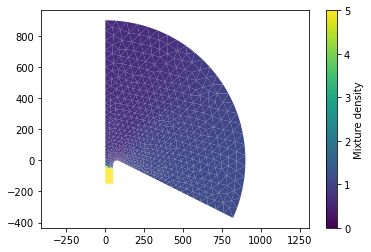

In [311]:
# (Import) Plot total density
import matplotlib.animation as animation

outfilename = "density_again_more"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(), f"{outfilename}.mp4")

# plot_idx = 20

for plot_idx in [i+1 for i in range(0,150,1)]:
  plt.clf()
  clims = (0,5)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    mdtools.plot_mean(x,
      np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True), clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("Mixture density")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

Done


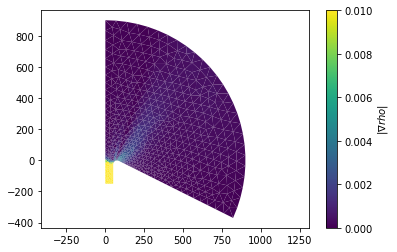

In [306]:
# (Import) Plot |grad rho|
import matplotlib.animation as animation

outfilename = "schlieren_close2"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(), f"{outfilename}.mp4")

# plot_idx = 20

for plot_idx in [i+1 for i in range(150)]:
  plt.clf()
  clims = (0,.01)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    sample_basis_phys_grad_elems = []
    sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
    for elem_ID in range(solver.mesh.num_elems):
      solver.basis.get_basis_val_grads(
              sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
              get_val=True,
              get_ref_grad=True,
              get_phys_grad=True,
              ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
      sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
    # du_ij = np.einsum('ijnl, ink -> ijkl',
    #       np.array(sample_basis_phys_grad_elems),
    #       solver.physics.compute_variable("Pressure", solver.state_coeffs))
    normgradp = np.linalg.norm(
      np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True)),
      axis=2, keepdims=True)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    mdtools.plot_mean(x, normgradp, clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("$|\\nabla rho|$")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

(0.0, 53.711649542839446)

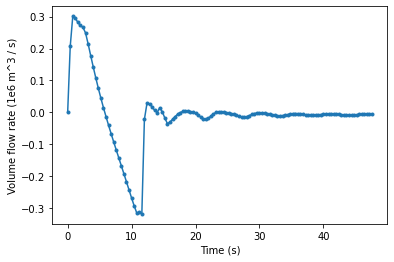

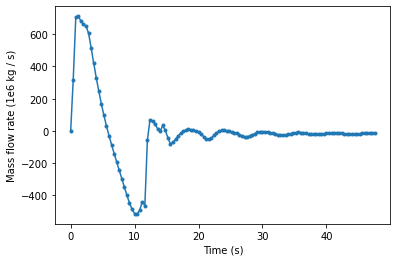

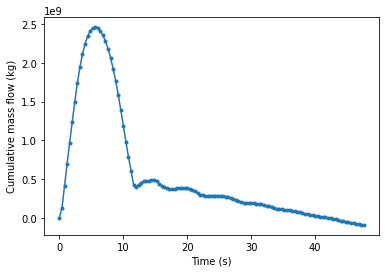

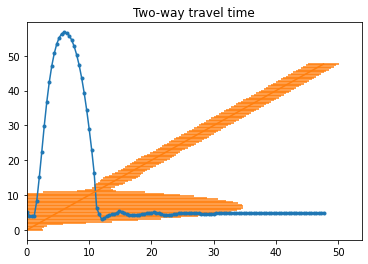

In [257]:
plt.figure(1)
plt.plot(t_volflow, volflow/1e6, '.-')
plt.ylabel("Volume flow rate (1e6 m^3 / s)")
plt.xlabel("Time (s)")

plt.figure(2)
plt.plot(t_volflow, massflow/1e6, '.-')
plt.ylabel("Mass flow rate (1e6 kg / s)")
plt.xlabel("Time (s)")

plt.figure(3)
plt.plot(t_volflow, np.diff(t_volflow)[0] * np.cumsum(massflow), '.-')

plt.ylabel("Cumulative mass flow (kg)")
plt.xlabel("Time (s)")


plt.figure(4)
plt.plot(t_volflow, 2*t_wavetravel_array, '.-')
plt.title("Two-way travel time")

plt.errorbar(t_volflow, t_volflow, xerr=t_wavetravel_array)
plt.xlim(left=0)

<ErrorbarContainer object of 3 artists>

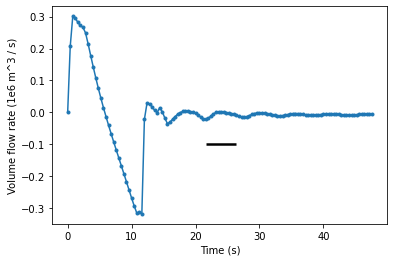

In [269]:
plt.figure(1)
plt.plot(t_volflow, volflow/1e6, '.-')
plt.ylabel("Volume flow rate (1e6 m^3 / s)")
plt.xlabel("Time (s)")

index_bar = 60
pos_bar = -0.1
plt.errorbar(t_volflow[index_bar], pos_bar, xerr=t_wavetravel_array[index_bar],  color='k', linewidth=2.5)

In [252]:
np.diff(t_volflow).shape

(119,)

In [ ]:
# Average conduit travel time

In [176]:
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung2_atm{j}_{i}.pkl")

# solver = solver2D_from(i,3)
# solver.mesh.node_coords.shape
x, p = mdtools.downsample(solver, plot_qty="Pressure")

''' Point evaluation (linear interp) '''
import matplotlib.tri as tri
# Global triangulation using node coordinates
trtr = tri.Triangulation(solver.mesh.node_coords[...,0],
                  solver.mesh.node_coords[...,1], 
                  triangles=solver.mesh.elem_to_node_IDs)
def interp_value(x, y, u):
  # Element ID finder using trifinder (-1 if not found)
  get_elem_ID = trtr.get_trifinder()(x, y)
  if get_elem_ID == -1:
    return None
  # Get relevant triangle (type is ndarray[3, 2])
  local_nodes = \
    solver.mesh.node_coords[solver.mesh.elem_to_node_IDs[get_elem_ID,:], :]
  # Use cubic tri interpolator on relevant tri element
  return np.array([tri.CubicTriInterpolator(
    tri.Triangulation(local_nodes[:,0],local_nodes[:,1]),
    u[get_elem_ID, :, i])(x,y) for i in range(u.shape[-1])])

# HIGH
# interp_value(1750, -825, p)
# LOW
# interp_value(3000, -1450, p)
sensor_loc = (1750, -825)

# Assuming global triangulation trtr is loaded with the same solver
all_t = []
all_val = []
for i in range(1100):
  solver = solver2D_from(i,3)
  _t = solver.time
  _val_global = solver.state_coeffs
  _val = interp_value(*sensor_loc, _val_global)
  all_t.append(_t)
  all_val.append(_val)

In [175]:
# Saving
# dat1 = {"all_t": all_t, "all_val": all_val}


C:\Users\Fredric\AppData\Local\Temp\ipykernel_32104\697551041.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t, p/u_norm, '.')


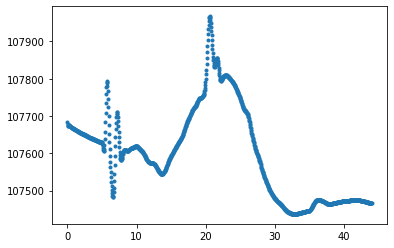

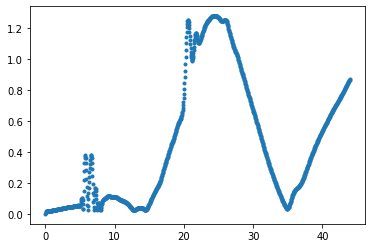

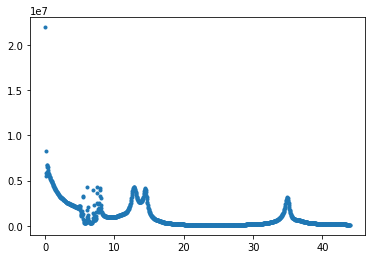

In [181]:
# Series analysis
t = np.array(all_t)
compute_qty = lambda qty : np.array([
  solver.physics.compute_variable(qty, np.expand_dims(state_coeffs,axis=(0,1))) 
  for state_coeffs in all_val])
p = compute_qty("Pressure").squeeze()
u_norm = compute_qty("Velocity").squeeze()
plt.figure(1)
plt.plot(t, p, '.')
plt.figure(2)
plt.plot(t, u_norm, '.')
plt.figure(3)
plt.plot(t, p/u_norm, '.')

Text(0.5, 0, 'Time (s)')

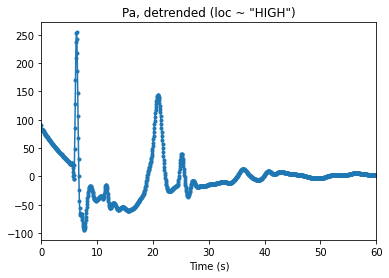

In [148]:
import scipy.signal
plt.plot(t, scipy.signal.detrend(p), '.-')
plt.title('Pa, detrended (loc ~ "HIGH")')
plt.xlim(0, 60)
plt.xlabel('Time (s)')

--------------------------------------------------------

Text(0, 0.5, 'rho u')

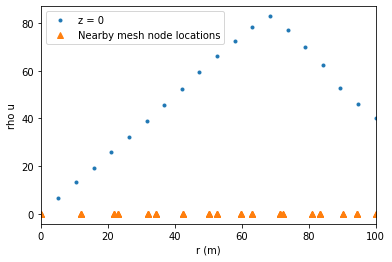

In [125]:
# Plot momentum along arbitrary probe line
xline = np.array([np.linspace(0, 100, 20), np.linspace(0, 0, 20)]).transpose()

solver = solver2D_from(i,1)
# rhou = plot.get_numerical_solution(solver.physics, solver.state_coeffs, xline,
					# solver.basis, "XMomentum"
solver.order, temp = 0, solver.order
xsoln = plot.get_sample_points(solver.mesh, solver, solver.physics, solver.basis, True)
solver.order = temp

var = plot.get_numerical_solution(solver.physics, solver.state_coeffs, xsoln,
	solver.basis, 'XMomentum')
rhou = plot.interpolate_2D_soln_to_points(solver.physics, xsoln, var, xline)

plt.plot(xline[:,0], rhou, '.')

# Filter nearby mesh nodes
mesh_x_vec = x1.reshape(-1, x1.shape[-1])
mesh_x_vec_near = np.array([pt[0] for pt in zip(mesh_x_vec) if np.abs(pt[0][1] - 0) < 10])
plt.plot(mesh_x_vec_near[:,0], 0*mesh_x_vec_near[:,0],'^')
plt.xlim((0,100))
plt.legend(["z = 0", "Nearby mesh node locations"])
plt.xlabel("r (m)")
plt.ylabel("rho u")

In [137]:
solver.physics.Gas[0]

{'R': 287.0, 'gamma': 1.4, 'c_v': 717.5000000000001, 'c_p': 1004.5000000000001}

In [127]:
%matplotlib tk
''' Animation for velocity component'''

from matplotlib.animation import FuncAnimation
# mdtools.viz(solver2D_from(0))
# clims = (-0.1e5, 0.1e5)
clims = (-10, 100)
_, v0 = mdtools.downsample(solver2D_from(0,1), plot_qty="XVelocity")

def animate(i):
  plt.clf()
  solver = solver2D_from(i,1)
  x, v = mdtools.downsample(solver, plot_qty="XVelocity")
  mdtools.plot_mean(x, v, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  plt.title(f"t = {solver.time}")

anim = FuncAnimation(plt.figure(), animate, frames=range(5,200,1), interval=1,
  repeat=True)
plt.show()

In [135]:
mdtools.generate_anim(["mixture_shocktube_atm1_cyl", "mixture_shocktube_atm2_cyl"], ["mixture_shocktube_conduit_cyl"], "cyl_test_p_all", 25,
  "Pressure", initial=1, stride=5, is_high_detail=False)
mdtools.generate_anim(["mixture_shocktube_atm1_cyl", "mixture_shocktube_atm2_cyl"], [], "cyl_test_r_velocity", 25,
  "XVelocity", initial=1, stride=5, is_high_detail=False)

Animation constructed
Animation constructed


------------------

----------

In [162]:
%matplotlib tk
''' Animation for log10(abs(delta p))'''

from matplotlib.animation import FuncAnimation
# mdtools.viz(solver2D_from(0))
# clims = (-0.1e5, 0.1e5)
clims = (0, 6)
_, p0 = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")

def animate(i):
  plt.clf()
  x, p = mdtools.downsample(solver2D_from(i), plot_qty="Pressure")
  mdtools.plot_mean(x, np.log10(np.abs(p-p0)), clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)

anim = FuncAnimation(plt.figure(), animate, frames=range(1,200,5), interval=1,
  repeat=True)
plt.show()

C:\Users\Fredric\AppData\Local\Temp\ipykernel_86072\2456651837.py:12: RuntimeWarning: divide by zero encountered in log10
  mdtools.plot_mean(x, np.log10(np.abs(p-p0)), clims)
